In [2]:
##########################################################
# This jupyter file needs these version of libraries
###########################################################

# import keras
# import tensorflow as tf
# import sklearn
# import pandas
# import numpy

# print('Using SKlearn version',sklearn.__version__)
# print('Using np version',np.__version__)
# print('Using pd version',pd.__version__)
# print('Using tf version',tf.__version__)
# print('Using keras version',keras.__version__)


# Using SKlearn version 0.23.2
# Using np version 1.19.5
# Using pd version 1.3.4
# Using tf version 2.6.0
# Using keras version 2.6.0

In [14]:
from copy import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import tensorflow as tf

In [3]:
# Read original files 
data1 = pd.read_csv('./data/PdM_errors.csv')
data2 = pd.read_csv('./data/PdM_telemetry.csv')
data3= pd.read_csv('./data/PdM_failures.csv')
data4= pd.read_csv('./data/PdM_machines.csv')
data5 = pd.read_csv ('./data/PdM_maint.csv')


In [4]:
# Prepare a failures file
data3['comp1_fail']=0
data3['comp2_fail']=0
data3['comp3_fail']=0
data3['comp4_fail']=0
counter=0
for itera in data3.failure:
    if itera=="comp1":
        data3.at[counter,'comp1_fail']=1
    elif itera=="comp2":
        data3.at[counter,'comp2_fail']=1
    elif itera=="comp3":
        data3.at[counter,'comp3_fail']=1
    elif itera=="comp4":
        data3.at[counter,'comp4_fail']=1
    counter=counter+1
data3=data3.drop(columns=['failure']) 
#ready faulure csv
data4=data4.drop(columns=['model'])

In [5]:
# Prepare an errors file
data1['error1']=0
data1['error2']=0
data1['error3']=0
data1['error4']=0
data1['error5']=0
counter = 0

for itera in data1.errorID:
    if itera=="error1":
        data1.at[counter,'error1']=1
    elif itera=="error2":
        data1.at[counter,'error2']=1
    elif itera=="error3":
        data1.at[counter,'error3']=1
    elif itera=="error4":
        data1.at[counter,'error4']=1
    elif itera=="error5":
        data1.at[counter,'error5']=1
    counter=counter+1
    
data1=data1.drop(columns=['errorID']) 



In [6]:
# Prepare a maintanance file 
data5 = data5[data5['datetime'] >= '2015']
data5['comp1_maint']=0
data5['comp2_maint']=0
data5['comp3_maint']=0
data5['comp4_maint']=0
counter=0
for itera in data5.comp:
    if itera=="comp1":
        data5.at[counter,'comp1_maint']=1
    elif itera=="comp2":
        data5.at[counter,'comp2_maint']=1
    elif itera=="comp3":
        data5.at[counter,'comp3_maint']=1
    elif itera=="comp4":
        data5.at[counter,'comp4_maint']=1
    counter=counter+1
data5=data5.drop(columns=['comp'])



In [7]:
# Merge all files in one file

output1 = pd.merge(data2, data1 ,on=['datetime','machineID'],how='left')

output2 = pd.merge(output1, data3 ,on=['datetime','machineID'],how='left')

output3 = pd.merge(output2, data5 ,on=['datetime','machineID'],how='left')

final_output = pd.merge(output3, data4 ,on='machineID',how='left') 
final_output = final_output.replace(np.nan, 0)
final_output = final_output.groupby(['machineID','datetime']).max()
final_output=final_output.reset_index()

final_output.head()

,machineID,datetime,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5,comp1_fail,comp2_fail,comp3_fail,comp4_fail,comp1_maint,comp2_maint,comp3_maint,comp4_maint,age
0,1,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
1,1,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
2,1,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
3,1,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
4,1,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18


In [12]:
features_col_name=['machineID','volt' , 'rotate' , 'pressure' , 'vibration' ,'error1','error2','error3','error4','error5','comp1_maint','comp2_maint','comp3_maint','comp4_maint','age']
target_col_day=['machineID','comp1_fail','comp2_fail','comp3_fail','comp4_fail']
features_col_name_sc=['volt' , 'rotate' , 'pressure' , 'vibration' ,'error1','error2','error3','error4','error5','comp1_maint','comp2_maint','comp3_maint','comp4_maint','age']
all_x = final_output[features_col_name]
all_y = final_output[target_col_day]
X_train_df = pd.DataFrame()
X_test_df = pd.DataFrame()
Y_train_df = pd.DataFrame()
Y_test_df = pd.DataFrame()


window = 8760
start = 0
stop = 8760
df_new_x=[None] * 100
df_new_y=[None] * 100
for i in range (0,100):
    df_new_x[i]=all_x.iloc[start:stop:]
    df_new_y[i]=all_y.iloc[start:stop:]
    start = stop+1
    stop = start + window

temp_list_1=[]
temp_list_2=[]
temp_list_3=[]
temp_list_4=[]
for i in range (0,100):
    temp_list_1.append(df_new_x[i].iloc[0:7320:])
    temp_list_2.append(df_new_x[i].iloc[7320:8760:])
    temp_list_3.append(df_new_y[i].iloc[0:7320:])
    temp_list_4.append(df_new_y[i].iloc[7320:8760:])
X_train_df = pd.concat(temp_list_1)
X_test_df = pd.concat(temp_list_2)
Y_train_df = pd.concat(temp_list_3)
Y_test_df = pd.concat(temp_list_4)

###########################
# WE NEED THIS SAMPLE DATAFRAME (TIME SERIES) FOR WEB APPLICATION
test=X_test_df.iloc[0:25, :].copy()
#########################

# FOR NORMALIZE
sc=MinMaxScaler()
sc.fit(X_train_df[features_col_name_sc])
X_train_df[features_col_name_sc]=sc.transform(X_train_df[features_col_name_sc])
X_test_df[features_col_name_sc]=sc.transform(X_test_df[features_col_name_sc])

X_train_df[:4]

,machineID,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5,comp1_maint,comp2_maint,comp3_maint,comp4_maint,age
0,1,0.513781,0.503194,0.459050,0.487945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9
1,1,0.426905,0.474884,0.328274,0.460912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9
2,1,0.479730,0.698752,0.178160,0.311752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9
3,1,0.424193,0.373197,0.430624,0.423896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9


In [17]:
# Save MinMaxScaler model and TEST dataframe for Web Application
test.to_csv('saved/test.csv', index=False)
pickle.dump(sc, open('saved/sc.pkl', 'wb'))

In [18]:
# Rolling window for training
# Take 24: 0-23 1-24 2-25 etc maybe create better accuracy

window_train_x =[]
counter = 0
temp_list=[]
last_id = 0
for index , row in X_train_df.iterrows():
    current_id = row['machineID']
    if current_id != last_id:
        temp_list = []
        temp_list.append([row['volt'] ,row['rotate'] , row['pressure'] , row['vibration'] ,row['error1'],row['error2'],row['error3'],row['error4'],row['error5'],row['comp1_maint'],row['comp2_maint'],row['comp3_maint'],row['comp4_maint'],row['age']])
        counter = 1
        #appe = copy(temp_list)
        #window_train_y_temp.append(appe)
    else:
        counter = counter +1
        temp_list.append([row['volt'] ,row['rotate'] , row['pressure'] , row['vibration'] ,row['error1'],row['error2'],row['error3'],row['error4'],row['error5'],row['comp1_maint'],row['comp2_maint'],row['comp3_maint'],row['comp4_maint'],row['age']])
        if counter == 24:
            counter = 23
            appe = copy(temp_list)
            window_train_x.append(appe)
            if len(temp_list)==24:
                del temp_list[0]
    last_id = current_id  

window_train_x=np.array(window_train_x)

In [19]:
# Rolling window for testing

window_test_x =[]
counter = 0
temp_list=[]
for index ,row in X_test_df.iterrows():
    current_id = row['machineID']
    if current_id != last_id:
        temp_list = []
        temp_list.append([row['volt'] ,row['rotate'] , row['pressure'] , row['vibration'] ,row['error1'],row['error2'],row['error3'],row['error4'],row['error5'],row['comp1_maint'],row['comp2_maint'],row['comp3_maint'],row['comp4_maint'],row['age']])
        counter = 1
        #appe = copy(temp_list)
        #window_train_y_temp.append(appe)
    else:
        counter = counter +1
        temp_list.append([row['volt'] ,row['rotate'] , row['pressure'] , row['vibration'] ,row['error1'],row['error2'],row['error3'],row['error4'],row['error5'],row['comp1_maint'],row['comp2_maint'],row['comp3_maint'],row['comp4_maint'],row['age']])
        if counter == 24:
            counter = 23
            appe = copy(temp_list)
            window_test_x.append(appe)
            if len(temp_list)==24:
                del temp_list[0]
    last_id = current_id 

window_test_x=np.array(window_test_x)

In [20]:
# Four labels as an output of Transformer model for training.

window_model_label_1=[]
window_model_label_2=[]
window_model_label_3=[]
window_model_label_4=[]
window_train_y=[]
window_train_y_temp =[]
counter = 0
temp_list=[]
last_id = 0

# print(f'First row: {Y_train_df.iloc[0,:]}')

for index , row in Y_train_df.iterrows():
    current_id = row['machineID']
    if current_id != last_id:
        temp_list = []
        temp_list.append([row['comp1_fail'],row['comp2_fail'],row['comp3_fail'],row['comp4_fail']])
        counter = 1
        #appe = copy(temp_list)
        #window_train_y_temp.append(appe)
    else:
        counter = counter +1
        temp_list.append([row['comp1_fail'],row['comp2_fail'],row['comp3_fail'],row['comp4_fail']])
        if counter == 24:
            counter = 23
            appe = copy(temp_list)
            window_train_y_temp.append(appe)
            if len(temp_list)==24:
                del temp_list[0]
    last_id = current_id  
    
# print('window_train_y_temp: ', len(window_train_y_temp))
    
for itera in window_train_y_temp:
    max_1=(max(itera, key=lambda x: x[0]))[0]
    max_2=(max(itera, key=lambda x: x[1]))[1]
    max_3=(max(itera, key=lambda x: x[2]))[2]
    max_4=(max(itera, key=lambda x: x[3]))[3]
    window_model_label_1.append(max_1)
    window_model_label_2.append(max_2)
    window_model_label_3.append(max_3)
    window_model_label_4.append(max_4)
    #list_max=[max_1, max_2, max_3, max_4]
    #window_train_y.append(list_max)

    
print('window_model_label_1: ', type(window_model_label_1), len(window_model_label_1))
print(window_model_label_1[:4])

window_model_label_1=np.array(window_model_label_1)
window_model_label_2=np.array(window_model_label_2)
window_model_label_3=np.array(window_model_label_3)
window_model_label_4=np.array(window_model_label_4)

window_model_label_1:  <class 'list'> 729700
[0.0, 0.0, 0.0, 0.0]


In [21]:
# Four labels as an output of Transformer model for testing.

window_model_test_1=[]
window_model_test_2=[]
window_model_test_3=[]
window_model_test_4=[]

window_test_y=[]
window_test_y_temp =[]
counter = 0
temp_list=[]
last_id = 0
for index , row in Y_test_df.iterrows():
    current_id = row['machineID']
    if current_id != last_id:
        temp_list = []
        temp_list.append([row['comp1_fail'],row['comp2_fail'],row['comp3_fail'],row['comp4_fail']])
        counter=1
        #appe = copy(temp_list)
        #window_test_y_temp.append(appe)
    else:
        counter = counter +1
        temp_list.append([row['comp1_fail'],row['comp2_fail'],row['comp3_fail'],row['comp4_fail']])
        if counter == 24:
            counter = 23
            appe = copy(temp_list)
            window_test_y_temp.append(appe)
            if len(temp_list)==24:
                del temp_list[0]
    last_id = current_id   
for itera in window_test_y_temp:
    max_1=(max(itera, key=lambda x: x[0]))[0]
    max_2=(max(itera, key=lambda x: x[1]))[1]
    max_3=(max(itera, key=lambda x: x[2]))[2]
    max_4=(max(itera, key=lambda x: x[3]))[3]
    window_model_test_1.append(max_1)
    window_model_test_2.append(max_2)
    window_model_test_3.append(max_3)
    window_model_test_4.append(max_4)

window_model_test_1=np.array(window_model_test_1)
window_model_test_2=np.array(window_model_test_2)
window_model_test_3=np.array(window_model_test_3)
window_model_test_4=np.array(window_model_test_4)   

## Build and train a Transformer model (Decoder model)

Learning rate schedule: 0.001 to 0.001 to 1e-06


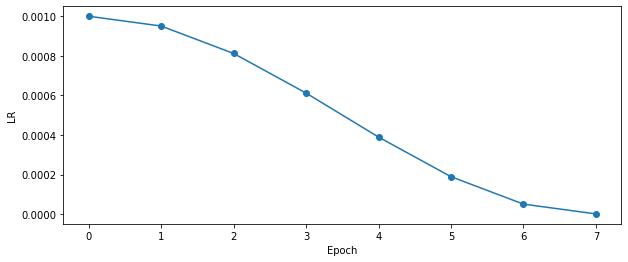

In [31]:
# This is just to show how "lrfn" function works.
# Graph shows learning rate for each Epochs

EPOCHS = 8

from model import lrfn

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))


In [ ]:
from model import build_model

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

model = build_model()
history = model.fit(window_train_x, {'comp1_fail': window_model_label_1,
                                           'comp2_fail':window_model_label_2,
                                          'comp3_fail':window_model_label_3,
                                          'comp4_fail':window_model_label_4}, 
                                          epochs=8,  batch_size=512, verbose=2, callbacks = [LR])


In [30]:
# saved weights of model for Web Application
model.save_weights('transformer_fold_0.h5')

## Testing performance of the model

In [28]:
# testing window_test_x data 
predicted_v0 = model.predict(np.array(window_test_x)) 
y_pred_comp1 = predicted_v0[0].flatten()
y_pred_comp2 = predicted_v0[1].flatten()
y_pred_comp3 = predicted_v0[2].flatten()
y_pred_comp4 = predicted_v0[3].flatten()

y_pred_classes_comp1= np.array(list(map(lambda x: 0 if x<0.5 else 1, y_pred_comp1)))
y_pred_classes_comp2= np.array(list(map(lambda x: 0 if x<0.5 else 1, y_pred_comp2)))
y_pred_classes_comp3= np.array(list(map(lambda x: 0 if x<0.5 else 1, y_pred_comp3)))
y_pred_classes_comp4= np.array(list(map(lambda x: 0 if x<0.5 else 1, y_pred_comp4)))

In [30]:
# Calculate Accuracy, Precision, Recall, and F1-Score for Fourth label of test dataset
cm=[[0,0],[0,0]]
for itera , iterb in zip(window_model_test_4,y_pred_classes_comp4):
    if (itera==iterb==0):
        #true negative
        cm[0][0]=cm[0][0]+1
    elif (itera==iterb==1):
        #true positive
        cm[1][1]=cm[1][1]+1
    elif(iterb==1):
        #false positive
        cm[1][0]=cm[1][0]+1
    elif(itera==1):
        #false negative
        cm[0][1]=cm[0][1]+1
print(cm[0][0])
print(cm[1][1])
print(cm[0][1])
print(cm[1][0])
#Accuracy
print('Accuracy : ', (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][0]+cm[0][1]+cm[1][1]))
#Recall
recall = (cm[1][1]/(cm[1][1]+cm[0][1]))
print('Recall : ', recall )
#Precision
precision = (cm[1][1]/(cm[1][1]+cm[1][0]))
print('Precision : ', precision )
#F1 Score
print('F1 score : ',2*precision*recall/(precision+recall))


141021
401
176
102
Accuracy :  0.9980381086803105
Recall :  0.6949740034662045
Precision :  0.7972166998011928
F1 score :  0.7425925925925926
